In [1]:
import collections
import copy
import sys
import time
from random import seed

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from torch import optim

import dataset
import evaluation
from GaussianDiffusion import GaussianDiffusionModel, get_beta_schedule
from helpers import *
from UNet import UNetModel, update_ema_params

torch.cuda.empty_cache()

ROOT_DIR = "./"
from PIL import Image

In [2]:
from torchvision import transforms

In [3]:
from helpers import load_parameters

In [4]:
import torch


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import json
import os
from collections import defaultdict

import torch
import torchvision.utils


def gridify_output(img, row_size=-1):
    scale_img = lambda img: ((img + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    return torchvision.utils.make_grid(scale_img(img), nrow=row_size, pad_value=-1).cpu().data.permute(
            0, 2,
            1
            ).contiguous().permute(
            2, 1, 0
            )


def defaultdict_from_json(jsonDict):
    func = lambda: defaultdict(str)
    dd = func()
    dd.update(jsonDict)
    return dd


def load_checkpoint(param, use_checkpoint, device):
    """
    loads the most recent (non-corrupted) checkpoint or the final model
    :param param: args number
    :param use_checkpoint: checkpointed or final model
    :return:
    """
    if not use_checkpoint:
        return torch.load(f'./model/diff-params-ARGS={param}/params-final.pt', map_location=device)
    else:
        checkpoints = os.listdir(f'./model/diff-params-ARGS={param}/checkpoint')
        checkpoints.sort(reverse=True)
        for i in checkpoints:
            try:
                file_dir = f"./model/diff-params-ARGS={param}/checkpoint/{i}"
                loaded_model = torch.load(file_dir, map_location=device)
                break
            except RuntimeError:
                continue
        return loaded_model


def load_parameters(device):
    """
    Loads the trained parameters for the detection model
    :return:
    """
    import sys
    params = os.listdir("./model")
    if ".DS_Store" in params:
        params.remove(".DS_Store")

    if params[0] == "CHECKPOINT":
        use_checkpoint = True
        params = params[1:]
    else:
        use_checkpoint = False
#     use_checkpoint = False
#     print(params)
    param = params[-1]
    if param.isnumeric():
        output = load_checkpoint(param, use_checkpoint, device)
    elif param[:4] == "args" and param[-5:] == ".json":
        output = load_checkpoint(param[4:-5], use_checkpoint, device)
    elif param[:4] == "args":
        output = load_checkpoint(param[4:], use_checkpoint, device)
    else:
        output = load_checkpoint(param[-2:], use_checkpoint, device)

    if "args" in output:
        args = output["args"]
    else:
        try:
            with open(f'./test_args/args{param[17:]}.json', 'r') as f:
                args = json.load(f)
            args['arg_num'] = param[17:]
            args = defaultdict_from_json(args)
        except FileNotFoundError:
            raise ValueError(f"args{param[17:]} doesn't exist for {param}")

    if "noise_fn" not in args:
        args["noise_fn"] = "gauss"

    return args, output


# def main():
#     pass


# if __name__ == '__main__':
#     main()


In [7]:
# args

In [8]:
args, output = load_parameters(device)

In [13]:
in_channels=1
unet = UNetModel(
        args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], in_channels=in_channels
        )

betas = get_beta_schedule(args['T'], args['beta_schedule'])

diff = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=in_channels
        )



In [14]:
# unet.load_state_dict()

In [15]:
unet.load_state_dict(output["ema"])
unet.to(device)
unet.eval()

UNetModel(
  (time_embedding): Sequential(
    (0): PositionalEmbedding()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (down): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (embed_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(128, 12

In [16]:
diff

In [17]:
args

defaultdict(str,
            {'img_size': [256, 256],
             'Batch_Size': 1,
             'EPOCHS': 4000,
             'T': 1000,
             'base_channels': 128,
             'channels': 1,
             'beta_schedule': 'cosine',
             'channel_mults': '',
             'loss-type': 'l2',
             'loss_weight': 'none',
             'train_start': True,
             'lr': 0.0001,
             'random_slice': False,
             'sample_distance': 800,
             'weight_decay': 0.0,
             'save_imgs': True,
             'save_vids': True,
             'dropout': 0,
             'attention_resolutions': '16,8',
             'num_heads': 2,
             'num_head_channels': -1,
             'noise_fn': 'simplex',
             'dataset': 'brats2021',
             'arg_num': '36'})

In [15]:
DATASET_PATH = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\Brain_Tumor\brain_tumor_dataset"

In [16]:
# Image.fromarray(img, mode='RGB')

In [17]:
d_set = dataset.AnoClsDataset(ROOT_DIR=f'{DATASET_PATH}', img_size=args['img_size'])

In [18]:
# data= dataset.TUMOR(input_size=args['img_size'], is_train=False)

In [19]:
data= dataset.MURA(input_size=256, is_train=False, subset= "HUMERUS")

In [20]:
A = []
B = []
for i in data:
    if i["label"] == 1:
        A.append(i)
    else:
        B.append(i)


C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [21]:
# for i in data:
#     print(i["label"])
# #         A.append(i)

In [22]:
# set_1 = d_set.__getitem__(-1)

In [130]:
img = A[5]["image"]

In [131]:
img.shape

torch.Size([3, 256, 256])

In [132]:
img = img.reshape(1, *img.shape)

In [133]:
img.shape

torch.Size([1, 3, 256, 256])

In [134]:
filenames = A[5]["label"]

In [135]:
filenames

1

In [136]:
img = img.cuda()
unet = unet.cuda()
# diff = diff.cuda()

In [85]:
output = diff.forward_backward(
                unet, img,
                see_whole_sequence=None,
                t_distance=200, denoise_fn=args["noise_fn"]
                )

In [137]:
output.shape

torch.Size([1, 3, 256, 256])

In [138]:
mse = (img - output).square()

In [139]:
mse.shape

torch.Size([1, 3, 256, 256])

In [140]:
mse.mean()

tensor(0.0144, device='cuda:0')

In [141]:
def t2img(image):
    '''
    :param image: image array(CHW) tensor
    :param coordinate: bounding boxs coordinate, coordinates.shape = [proposalN, 4], coordinates[0] = (x0, y0, x1, y1)
    :return:image with bounding box(HWC)
    '''

    if type(image) is not np.ndarray:
        image = image.clone().detach()

        rgbN = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 255, 0), (0, 255, 0), (0, 255, 0), (0, 255, 0)]

        # Anti-normalization
        std = [0.5, 0.5, 0.5]
        mean = [0.5, 0.5, 0.5]
        image[0] = image[0] * std[0] + mean[0]
        image[1] = image[1] * std[1] + mean[1]
        image[2] = image[2].mul(std[2]) + mean[2]
        image = image.mul(255).byte()

        image = image.data.cpu().numpy()

        image.astype(np.uint8)

        image = np.transpose(image, (1, 2, 0))  # CHW --> HWC
        image = image.copy()
        return image


In [142]:
# image = np.transpose(mse[0].cpu(), (1, 2, 0))

In [143]:
# image.shape
img.shape

torch.Size([1, 3, 256, 256])

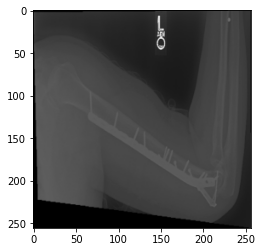

In [144]:
# image = np.transpose(img[0].cpu(), (1, 2, 0))
image = t2img(img[0])
plt.imshow(image)

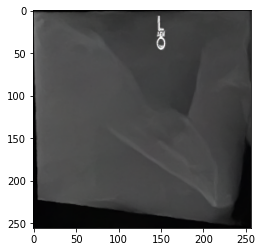

In [145]:
image = t2img(output[0])
# image = np.transpose(output[0].cpu(), (1, 2, 0))
plt.imshow(image)

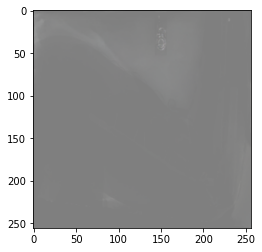

In [146]:
image = t2img(mse[0])
# image = np.transpose(mse[0].cpu(), (1, 2, 0))
plt.imshow(image)

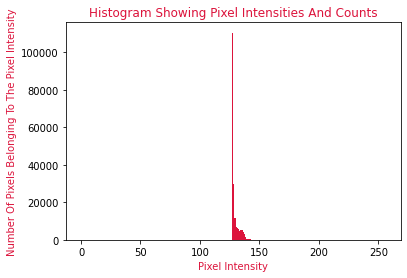

In [147]:
import matplotlib.pyplot as plt
plt.hist(x=image.ravel(), bins=256, range=[0, 256], color='crimson')
plt.title("Histogram Showing Pixel Intensities And Counts", color='crimson')
plt.ylabel("Number Of Pixels Belonging To The Pixel Intensity", color="crimson")
plt.xlabel("Pixel Intensity", color="crimson")
plt.show()

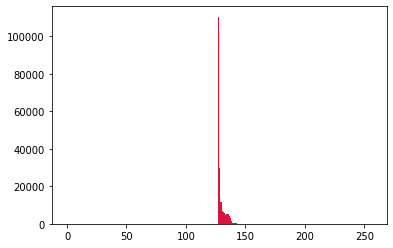

In [148]:
x= plt.hist(x=image.ravel(), bins=256, range=[0, 256], color='crimson')

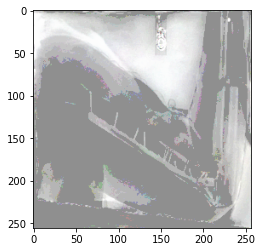

In [163]:
from skimage.exposure import equalize_hist
image_enhanced = equalize_hist(image)
plt.imshow(image_enhanced)
# cv2.imshow("Enhanced Contrast", image_enhanced)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [166]:
image_enhanced[(image_enhanced > 0.8) & (image_enhanced < 0.5)] = 255

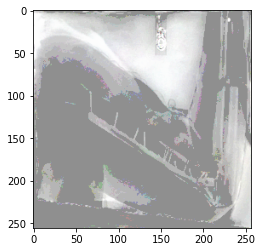

In [167]:
plt.imshow(image_enhanced)

In [168]:
image_enhanced.max()

1.0

In [169]:
image_enhanced.mean()

0.6741609143403667

In [170]:
# img = Image.fromarray(c

In [ ]:
img.show()

In [ ]:
img = transforms.ToPILImage(image[0])